10. We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. 
We will now explore this in a simulated data set.

In [106]:
library("ISLR2")
#library("MASS")
library("ggplot2")
library("ggthemes")
#library("boot")
library("skimr")
library("caret")
library("leaps")
library("glmnet")
library("pls")
library("patchwork")
library("corrplot")
library("tidyverse")

# Define a color cycle to use
colors <- colorblind_pal()(8)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



(a) Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model

$y = X \beta + \epsilon,$

where $\beta$ has some elements that are exactly equal to zero.

In [28]:
p <- 20
n <- 1000

In [43]:
set.seed(1)

X <- matrix(data = rnorm(n * p), nrow = n, ncol = p)
cat("Dimension of X: ", dim(X), "\n")

zeros_ones <- sample(c(0, 1), 20, replace = T, prob = c(0.2, 0.8))
coeffs <- sample(seq(-1, 0.9, by = 0.1), 20, replace = F)
betas <- coeffs * zeros_ones
cat("Coefficients: ", betas, "\n")

epsilon <- rnorm(1000, sd = 0.25)

y <- X %*% betas + epsilon
cat("Dimension of y: ", dim(y), "\n")

Dimension of X:  1000 20 
Coefficients:  0.8 -1 0.1 -0.9 -0.6 -0.8 0.4 0 0 -0.1 0.5 0 -0.5 0.6 -0.4 0.2 0 0.3 0.9 0 
Dimension of y:  1000 1 


In [44]:
Xy <- data.frame(X = X, y = y)
head(Xy)

,X.1,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,⋯,X.12,X.13,X.14,X.15,X.16,X.17,X.18,X.19,X.20,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.6264538,1.13496509,-0.88614959,0.7391149,-1.1346302,-1.5163733,-0.61882708,-1.3254177,0.2637034,-1.2171201,⋯,-1.4115219,-0.93910663,0.2264537,0.5232667,-0.2139090,0.8576341,1.0496171,0.9514099,-2.07771241,1.325187
2,0.1836433,1.11193185,-1.92225490,0.3866087,0.7645571,0.6291412,-1.10942196,0.9519797,-0.8294518,-0.9462293,⋯,1.0838697,1.39366493,-0.8185942,0.9935537,-0.1067233,-1.6253951,0.2903237,0.4570987,-0.45446091,-4.203505
3,-0.8356286,-0.87077763,1.61970074,1.2963972,0.5707101,-1.6781940,-2.17033523,0.8600044,-1.4616348,0.0914098,⋯,1.1702224,1.62581486,-0.8471526,0.2737370,-0.4645893,-0.2342783,1.2421262,-0.3586935,-0.16555991,-2.550363
4,1.5952808,0.21073159,0.51926990,-0.8035584,-1.3516939,1.1797811,-0.03130307,1.0607903,1.6839902,0.7013513,⋯,0.2947545,0.40900106,-1.9843326,-0.6949193,-0.6842725,-1.0326545,-0.6850857,-1.0458614,0.89765209,-1.653496
5,0.3295078,0.06939565,-0.05584993,-1.6026257,-2.0298855,1.1176545,-0.26039848,-0.3505840,-1.5443243,0.6734224,⋯,-0.5544277,-0.09255856,-0.8127788,-0.7180502,-0.7908007,-1.1411412,-0.6677681,0.3075345,-0.02948916,1.436817
6,-0.8204684,-1.66264885,0.69641761,0.9332510,0.5904787,-1.2377359,0.53443047,-0.1307656,-0.1908871,1.2655534,⋯,-0.4034407,0.20609871,1.4616707,-0.1019895,-0.3389638,-1.5219369,0.9409138,1.9943876,1.85838843,3.187994


(b) Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [45]:
train_rows <- createDataPartition(Xy$y, p = 0.1, list = F)

Xy_train <- Xy[train_rows, ]
Xy_test <- Xy[-train_rows, ]

cat("Dimension of training set: ", dim(Xy_train), "\n")
cat("Dimension of testing set: ", dim(Xy_test), "\n")


Dimension of training set:  100 21 
Dimension of testing set:  900 21 


(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

We do not perform any data preprocessing as the data was generated by simulation from a normal distribution.

In [74]:
regsub_fit <- regsubsets(
    y ~ ., Xy_train,
    nvmax = 20
)

regsub_summary <- summary(regsub_fit)

In [68]:
idx <- c(
    which.min(regsub_summary$cp),
    which.min(regsub_summary$bic),
    which.max(regsub_summary$adjr2),
    which.min(regsub_summary$rss)
)

data.frame(
    row.names = c("cp", "bic", "adjr2", "mse"),
    model = idx,
    value = c(
        regsub_summary$cp[idx[1]],
        regsub_summary$bic[idx[2]],
        regsub_summary$adjr2[idx[3]],
        regsub_summary$adjr2[idx[4]] / n
    )
)

,model,value
,<int>,<dbl>
cp,16,1.582156e+01
bic,15,-3.891582e+02
adjr2,17,9.888241e-01
mse,20,9.886437e-04


In [49]:
regsub_summary$outmat

,X.1,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,X.11,X.12,X.13,X.14,X.15,X.16,X.17,X.18,X.19,X.20
1 ( 1 ),,,,,,,,,,,,,,,,,,,*,
2 ( 1 ),,*,,,,,,,,,,,,,,,,,*,
3 ( 1 ),,*,,*,,,,,,,,,,,,,,,*,
4 ( 1 ),,*,,*,,,,,,,,,,*,,,,,*,
5 ( 1 ),*,*,,*,,,,,,,,,,*,,,,,*,
6 ( 1 ),*,*,,*,,,,,,,*,,,*,,,,,*,
7 ( 1 ),*,*,,*,,*,,,,,*,,,*,,,,,*,
8 ( 1 ),*,*,,*,,*,,,,,*,,*,*,,,,,*,
9 ( 1 ),*,*,,*,*,*,,,,,*,,*,*,,,,,*,
10 ( 1 ),*,*,,*,*,*,,,,,*,,*,*,*,,,,*,


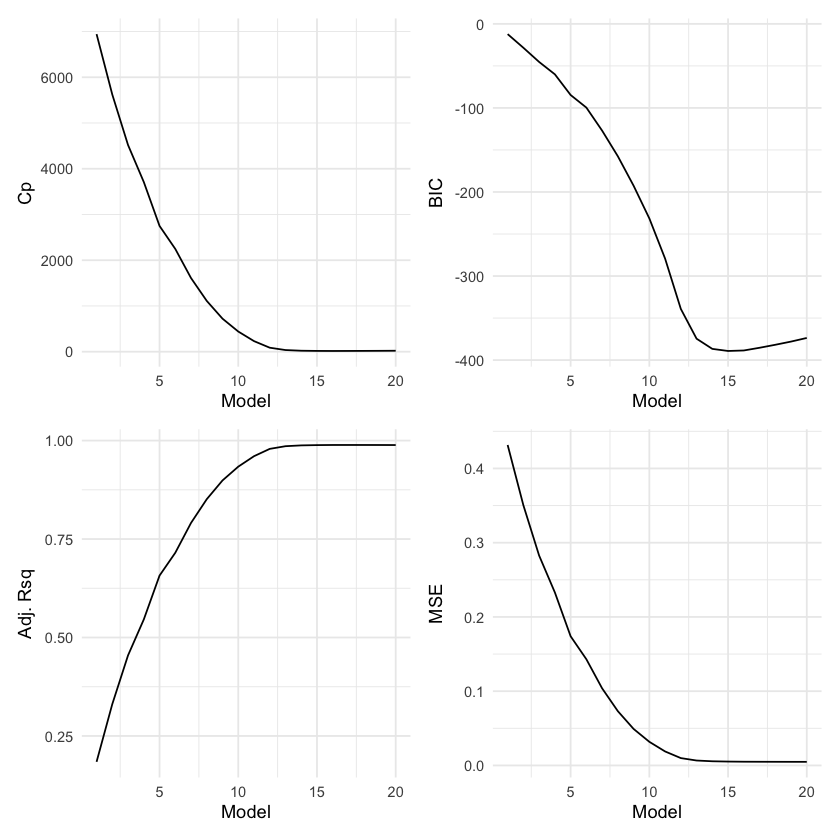

In [56]:
df_res <- data.frame(
    model = seq(20),
    cp = regsub_summary$cp,
    bic = regsub_summary$bic,
    adjr2 = regsub_summary$adjr2,
    mse = regsub_summary$rss / n
)

p1 <- ggplot(df_res, aes(x = model, y = cp)) +
    geom_line() +
    xlab("Model") +
    ylab("Cp") +
    theme_minimal()
p2 <- ggplot(df_res, aes(x = model, y = bic)) +
    geom_line() +
    xlab("Model") +
    ylab("BIC") +
    theme_minimal()
p3 <- ggplot(df_res, aes(x = model, y = adjr2)) +
    geom_line() +
    xlab("Model") +
    ylab("Adj. Rsq") +
    theme_minimal()
p4 <- ggplot(df_res, aes(x = model, y = mse)) +
    geom_line() +
    xlab("Model") +
    ylab("MSE") +
    theme_minimal()

p1 + p2 + p3 + p4

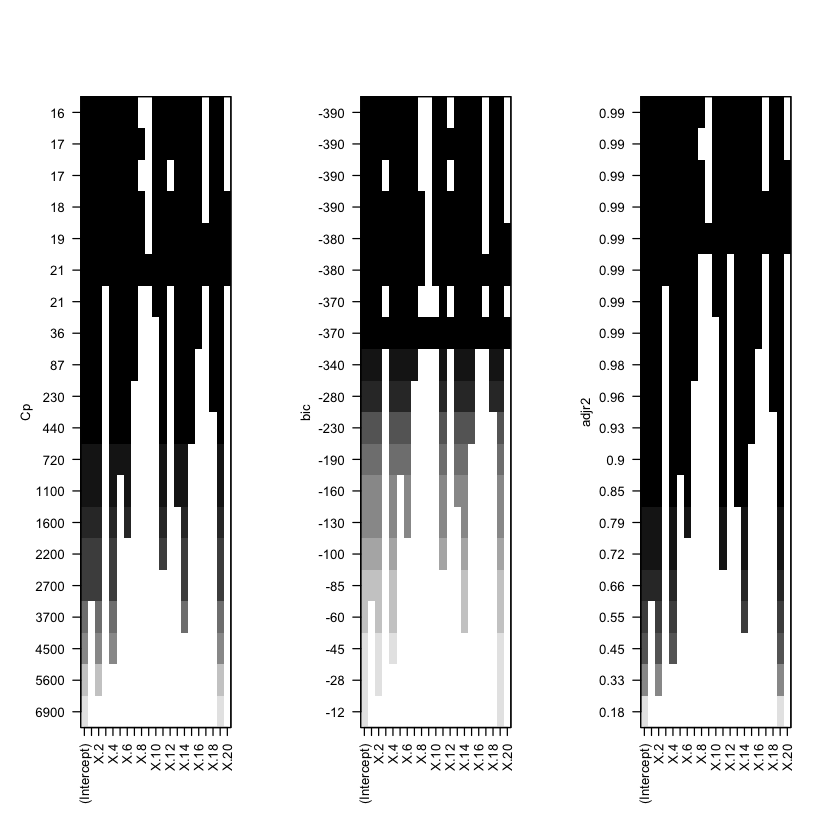

In [66]:
par(mfrow = c(1, 3))
plot(regsub_fit, scale = "Cp")
plot(regsub_fit, scale = "bic")
plot(regsub_fit, scale = "adjr2")

(d) Plot the test set MSE associated with the best model of each size.

In [ ]:
predict_regsubsets <- function(obj, newdata, id, ...) {
    form <- as.formula(obj$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(obj, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

In [152]:
regsub_test_error <- numeric(length = p)
for (i in seq(p)) {
    pred <- predict_regsubsets(regsub_fit, Xy_test, id = i)
    regsub_test_error[i] <- mean((Xy_test$y - pred)^2)
}

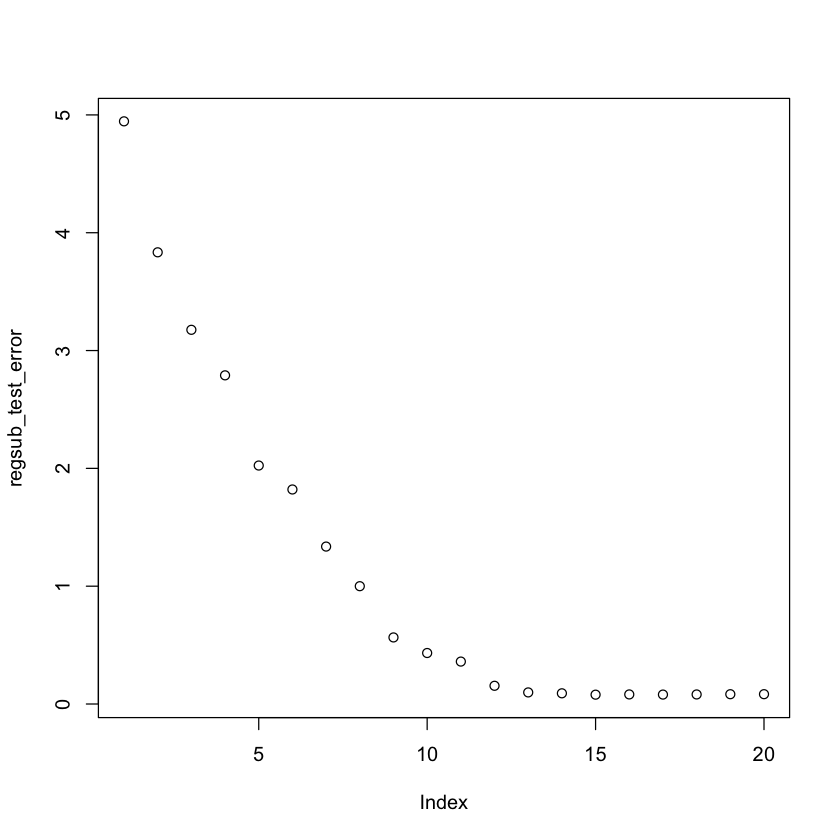

In [153]:
plot(regsub_test_error)

(e) For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

In [156]:
regsub_test_error[which.min(regsub_test_error)]
which.min(regsub_test_error)

[1] 0.07925224

[1] 15

In [161]:
(regsub_summary$rss / n)[15]

[1] 0.005222229

(f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data?

In [160]:
print(coef(regsub_fit, 15))

 (Intercept)          X.1          X.2          X.3          X.4          X.5 
-0.001421564  0.820248880 -0.977693540  0.076229985 -0.915219433 -0.567628435 
         X.6          X.7         X.10         X.11         X.13         X.14 
-0.783694695  0.373553580 -0.118064528  0.508571293 -0.507172070  0.677637978 
        X.15         X.16         X.18         X.19 
-0.420078510  0.198760056  0.326975975  0.912986086 


In [162]:
betas

[1]  0.8 -1.0  0.1 -0.9 -0.6 -0.8  0.4  0.0  0.0 -0.1  0.5  0.0 -0.5  0.6 -0.4
[16]  0.2  0.0  0.3  0.9  0.0

In [171]:
data.frame(
    test.coef = coef(regsub_fit, 15),
    betas = c(0.0, betas[-c(8, 9, 12, 17, 20)]))

,test.coef,betas
,<dbl>,<dbl>
(Intercept),-0.001421564,0.0
X.1,0.820248880,0.8
X.2,-0.977693540,-1.0
X.3,0.076229985,0.1
X.4,-0.915219433,-0.9
X.5,-0.567628435,-0.6
X.6,-0.783694695,-0.8
X.7,0.373553580,0.4
X.10,-0.118064528,-0.1
